In [1]:
import os
from torch.utils.data import DataLoader
from configuration import Configuration
from net.mask_rcnn import MaskRcnnNet
from loader.dsb2018.train_utils import *

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def submit_augment(image, index):
    pad_image = pad_to_factor(image, factor=16)
    input = torch.from_numpy(pad_image.transpose((2, 0, 1))).float().div(255)
    return input, image, index

def submit_collate(batch):
    batch_size = len(batch)
    inputs = torch.stack([batch[b][0] for b in range(batch_size)], 0)
    images = [batch[b][1] for b in range(batch_size)]
    indices = [batch[b][2] for b in range(batch_size)]
    return [inputs, images, indices]

In [6]:
# init dataset and dataloader!
cfg = Configuration()
test_dataset = ScienceDataset(cfg, 'test/data/valid43', mode='test', transform=submit_augment)
test_loader = DataLoader(
        test_dataset,
        sampler=SequentialSampler(test_dataset),
        batch_size=1,
        drop_last=False,
        num_workers=4,
        pin_memory=True,
        collate_fn=submit_collate)

image index:  1 tensor size:  torch.Size([3, 256, 256])


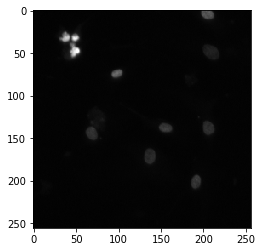

In [7]:
# get first batch of the data!
for i, (inputs, images, indices) in enumerate(test_loader, 0):
    if i == 1:  # pick one picture of the batch!
        tensor = inputs[0]
        image  = images[0]
        index = indices[0]
        break
print('image index: ', index, 'tensor size: ', tensor.size())
plt.imshow(image)

In [8]:
# init network from pretrained model!
net = MaskRcnnNet(cfg).to(cfg.device)
net.load_pretrain('00001000_model.pth')

In [9]:
# run prediction! it will take a few seconds if you use cpu
net.set_mode('test')
with torch.no_grad():
    net(inputs.to(cfg.device))

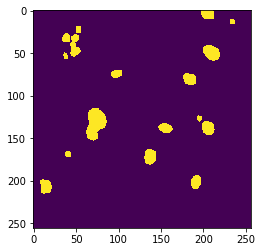

In [10]:
# get the first mask from the batch!
mask = net.masks[0]
plt.imshow(mask != 0)

In [11]:
# what about boxes?
boxes = net.detections[:, 1:5].numpy()

In [12]:
len(net.mask_instances[0])

21

In [13]:
# take a look of top 10 boxes, they are [x0, y0, x1, y1]
boxes.shape, boxes[:10]

((21, 4), array([[ 32.,  25.,  46.,  39.],
        [ 89.,  67., 108.,  83.],
        [127., 159., 148., 185.],
        [183., 191., 200., 213.],
        [144., 130., 166., 147.],
        [ 42.,  41.,  58.,  56.],
        [ 43.,  26.,  56.,  39.],
        [195., 126., 217., 151.],
        [194.,   0., 217.,  14.],
        [196.,  37., 224.,  63.]], dtype=float32))

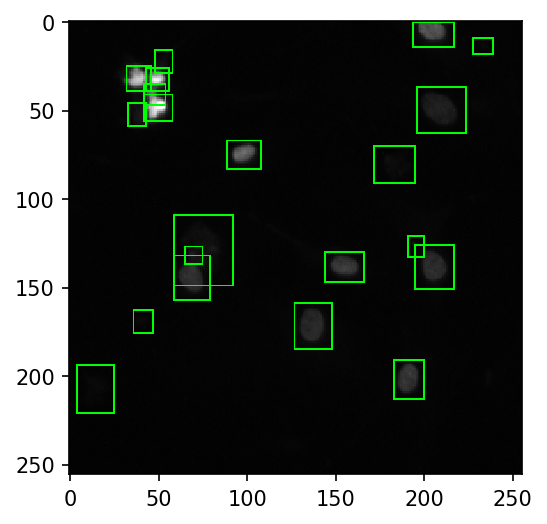

In [14]:
from visualize_utils.draw import draw_boxes
# Let's draw them out!
mpl.rcParams['figure.dpi'] = 150
draw_boxes(image, boxes, color=(0, 255, 0))
plt.imshow(image)